In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import numpy as np 
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
import umap
import matplotlib
%matplotlib inline
import pickle
import sklearn
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import os
# Specify the working directory
os.chdir('/Users/david/Desktop/TransferGPT')

# import sentence_transformers
plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [ ]:
gene_info_table = pd.read_csv('./data/Data_application/gene_info_table.csv')

In [ ]:
train_text_GGI1 = pd.read_csv('./gpt_descriptions/hs_gpt_general_hallmark_45_pw_embedding.csv', sep=',')
train_text_GGI2 = pd.read_csv('./gpt_descriptions/hs_gpt_general_hallmark_five_pw_embedding.csv', sep=',')
train_text_GGI = pd.concat([train_text_GGI1, train_text_GGI2])
# Set the first column as the index
train_text_GGI.set_index(train_text_GGI.columns[0], inplace=True)

df_dict_split = train_text_GGI.to_dict(orient='split')
GPT_4_gene_embeddings = dict(zip(df_dict_split['index'], df_dict_split['data']))

In [ ]:
with open(f"./GenePT/data_embedding/GPT_3_5_gene_embeddings.pickle", "rb") as fp:
    GPT_3_5_gene_embeddings = pickle.load(fp)

GPT4_keys = GPT_4_gene_embeddings.keys()
GPT3_5_keys = GPT_3_5_gene_embeddings.keys()
overlap_keys = list(set(GPT3_5_keys) & set(GPT4_keys))
print(len(overlap_keys))

# Create a new dictionary with only the specified keys
GPT_3_5_gene_embeddings = {key: GPT_3_5_gene_embeddings[key] for key in overlap_keys}

4364


In [ ]:
# Create random embeddings as negative controls
np.random.seed(2023)
N_DIM = 1536
fake_pretrain_embed = dict()
for key in GPT_3_5_gene_embeddings.keys():
    fake_pretrain_embed[key] = np.random.normal(size=(N_DIM))

In [ ]:
# Create a new column "gpt_embed" with default value as False
gene_info_table['gpt_embed'] = False

# Update the new column based on the condition
def check_embedding(row):
    gene = row['gene_name']
    if gene in GPT_3_5_gene_embeddings:
        embed_value = GPT_3_5_gene_embeddings[gene]
        if np.any(embed_value != 0):
            return True
    return False

gene_info_table['gpt_embed'] = gene_info_table.apply(check_embedding, axis=1)
# Create a subset where gpt_embed is True
subset = gene_info_table[gene_info_table['gpt_embed']]

# Find gene_type elements with occurrences > 50 (in this case, just for demonstration, I'll use > 2)
gene_type_counts = subset['gene_type'].value_counts()
common_gene_types = gene_type_counts[gene_type_counts > 75].index

# Create a final subset of the original DataFrame with only these gene_type elements
final_subset = gene_info_table[(gene_info_table['gene_type'].isin(common_gene_types))\
                               &(gene_info_table['gpt_embed'])]

# let's do a very simple classification for final_subset
X_list = []
y_list = []
# Iterate through rows of final_subset
for index, row in final_subset.iterrows():
    gene_name = row['gene_name']
    gene_type = row['gene_type']
    # Add the embedding from the dictionary to the x list
    if gene_name in GPT_3_5_gene_embeddings:
        X_list.append(GPT_3_5_gene_embeddings[gene_name])
    
    # Add the gene_type to the y list
        y_list.append(gene_type)

## Gene-gene interaction prediction
#### We showcase the gene-gene interaction prediction use case below. The input data can be downloaded from https://github.com/jingcheng-du/Gene2vec repo.

In [ ]:
# gene gene interaction 
train_text_GGI = pd.read_csv('./data/Data_application/train_text.txt',sep=' ',
                            header=None)
train_label_GGI = pd.read_csv('./data/Data_application/train_label.txt',
                              header=None)
train_text_GGI.columns = ['gene_1','gene_2']
train_label_GGI.columns = ['label']
train_text_GGI_df = pd.concat([train_text_GGI,train_label_GGI], axis=1)

In [ ]:
#gene gene interaction
test_text_GGI = pd.read_csv('./data/Data_application/test_text.txt',sep=' ',
                            header=None)
test_label_GGI = pd.read_csv('./data/Data_application/test_label.txt',
                            header=None)
test_text_GGI.columns = ['gene_1','gene_2']
test_label_GGI.columns = ['label']
test_text_GGI_df = pd.concat([test_text_GGI,test_label_GGI], axis=1)

### We choose a simple featurization scheme by *adding* the emebdding vectors of the two genes together:

In [ ]:
X_array_train = []
y_array_train = []
for i, row in train_text_GGI_df.iterrows():
    if row['gene_1'] in  GPT_3_5_gene_embeddings \
        and row['gene_2'] in GPT_3_5_gene_embeddings:
        X_array_train.append(GPT_3_5_gene_embeddings[row['gene_1']]+\
                             GPT_3_5_gene_embeddings[row['gene_2']])
        y_array_train.append(row['label'])
X_array_train = np.array(X_array_train)
y_array_train = np.array(y_array_train)
X_array_train = X_array_train.reshape(X_array_train.shape[0],-1)

X_array_test = []
y_array_test = []
for i, row in test_text_GGI_df.iterrows():
    if row['gene_1'] in  GPT_3_5_gene_embeddings \
        and row['gene_2'] in GPT_3_5_gene_embeddings:
        X_array_test.append(GPT_3_5_gene_embeddings[row['gene_1']]+\
                             GPT_3_5_gene_embeddings[row['gene_2']])
        y_array_test.append(row['label'])
X_array_test = np.array(X_array_test)
y_array_test = np.array(y_array_test)
X_array_test = X_array_test.reshape(X_array_test.shape[0],-1)

In [ ]:
# try the drug one...
# how do we featurize 
# simplest way is to just take the union of the two input features
X_array_train_random = []
y_array_train_random = []
for i, row in train_text_GGI_df.iterrows():
    if row['gene_1'] in  fake_pretrain_embed \
        and row['gene_2'] in fake_pretrain_embed:
#         X_array_train_random.append([fake_pretrain_embed[row['gene_1']],\
#                              fake_pretrain_embed[row['gene_2']]])
        X_array_train_random.append(fake_pretrain_embed[row['gene_1']]+
                             fake_pretrain_embed[row['gene_2']])
        y_array_train_random.append(row['label'])
X_array_train_random = np.array(X_array_train_random)
y_array_train_random = np.array(y_array_train_random)
X_array_train_random = X_array_train_random.reshape(X_array_train_random.shape[0],-1)

# how do we featurize 
# simplest way is to just take the union of the two input features
X_array_test_random = []
y_array_test_random = []
for i, row in test_text_GGI_df.iterrows():
    if row['gene_1'] in  fake_pretrain_embed \
        and row['gene_2'] in fake_pretrain_embed:
        X_array_test_random.append(fake_pretrain_embed[row['gene_1']]+
                             fake_pretrain_embed[row['gene_2']])
        y_array_test_random.append(row['label'])
X_array_test_random = np.array(X_array_test_random)
y_array_test_random = np.array(y_array_test_random)
X_array_test_random = X_array_test_random.reshape(X_array_test_random.shape[0],-1)

In [ ]:
gene2vec_dim_200_iter_9 = pd.read_csv('./data/Data_application/gene2vec_dim_200_iter_9.txt',\
                                      header=None,
                                     sep='\t')
pretrain_embed = {}  # Dictionary to hold gene_name: 200-dimensional vector

for index, row in gene2vec_dim_200_iter_9.iterrows():
    gene_name = row[0]
    vector_str = row[1]
    vector = [float(x) for x in vector_str.split()]  
    # Split the string into list of strings, then convert to floats
    if len(vector) == 200:  # Ensure the row has exactly 200 numbers
        pretrain_embed[gene_name] = np.array(vector)

In [ ]:
# try the drug one...
# how do we featurize 
# simplest way is to just take the union of the two input features
X_array_train_gene2vec = []
y_array_train_gene2vec = []
for i, row in train_text_GGI_df.iterrows():
    if row['gene_1'] in  pretrain_embed \
        and row['gene_2'] in pretrain_embed:
        X_array_train_gene2vec.append(pretrain_embed[row['gene_1']]+
                             pretrain_embed[row['gene_2']])
        y_array_train_gene2vec.append(row['label'])
X_array_train_gene2vec = np.array(X_array_train_gene2vec)
y_array_train_gene2vec = np.array(y_array_train_gene2vec)
X_array_train_gene2vec = X_array_train_gene2vec.reshape(X_array_train_gene2vec.shape[0],-1)


X_array_test_gene2vec = []
y_array_test_gene2vec = []
for i, row in test_text_GGI_df.iterrows():
    if row['gene_1'] in  pretrain_embed \
        and row['gene_2'] in pretrain_embed:
        X_array_test_gene2vec.append(pretrain_embed[row['gene_1']]+
                             pretrain_embed[row['gene_2']])
        y_array_test_gene2vec.append(row['label'])
X_array_test_gene2vec = np.array(X_array_test_gene2vec)
y_array_test_gene2vec = np.array(y_array_test_gene2vec)
X_array_test_gene2vec = X_array_test_gene2vec.reshape(X_array_test_gene2vec.shape[0],-1)

#### Replace the LogisticRegression() to RandomForest classifier to replace the results in the paper (slightly better AUC for GenePT and Gene2vec embeddings); we used the much faster LogisticRegression for illustration purposes here.  

In [ ]:
# Using Random Forest for gene2vec data
rf_gene2vec = LogisticRegression()  # You can add hyperparameters like n_estimators if needed
rf_gene2vec.fit(X_array_train_gene2vec, y_array_train_gene2vec)
y_pred_rf_gene2vec = rf_gene2vec.predict_proba(X_array_test_gene2vec)

# Using Random Forest for random data
rf_random = LogisticRegression()  # You can add hyperparameters like n_estimators if needed
rf_random.fit(X_array_train_random, y_array_train_random)
y_pred_rf_random = rf_random.predict_proba(X_array_test_random)

# Using Random Forest for the GenePT data
rf = LogisticRegression()  # You can add hyperparameters like n_estimators if needed
rf.fit(X_array_train, y_array_train)
y_pred_rf = rf.predict_proba(X_array_test)

# Computing the ROC curve with _rf suffix
fpr_rf, tpr_rf, _ = sklearn.metrics.roc_curve(y_array_test, y_pred_rf[:, 1])
fpr_random_rf, tpr_random_rf, _ = sklearn.metrics.roc_curve(y_array_test_random, y_pred_rf_random[:, 1])
fpr_gene2vec_rf, tpr_gene2vec_rf, _ = sklearn.metrics.roc_curve(y_array_test_gene2vec, y_pred_rf_gene2vec[:, 1])

/Users/david/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 640x480 with 0 Axes>

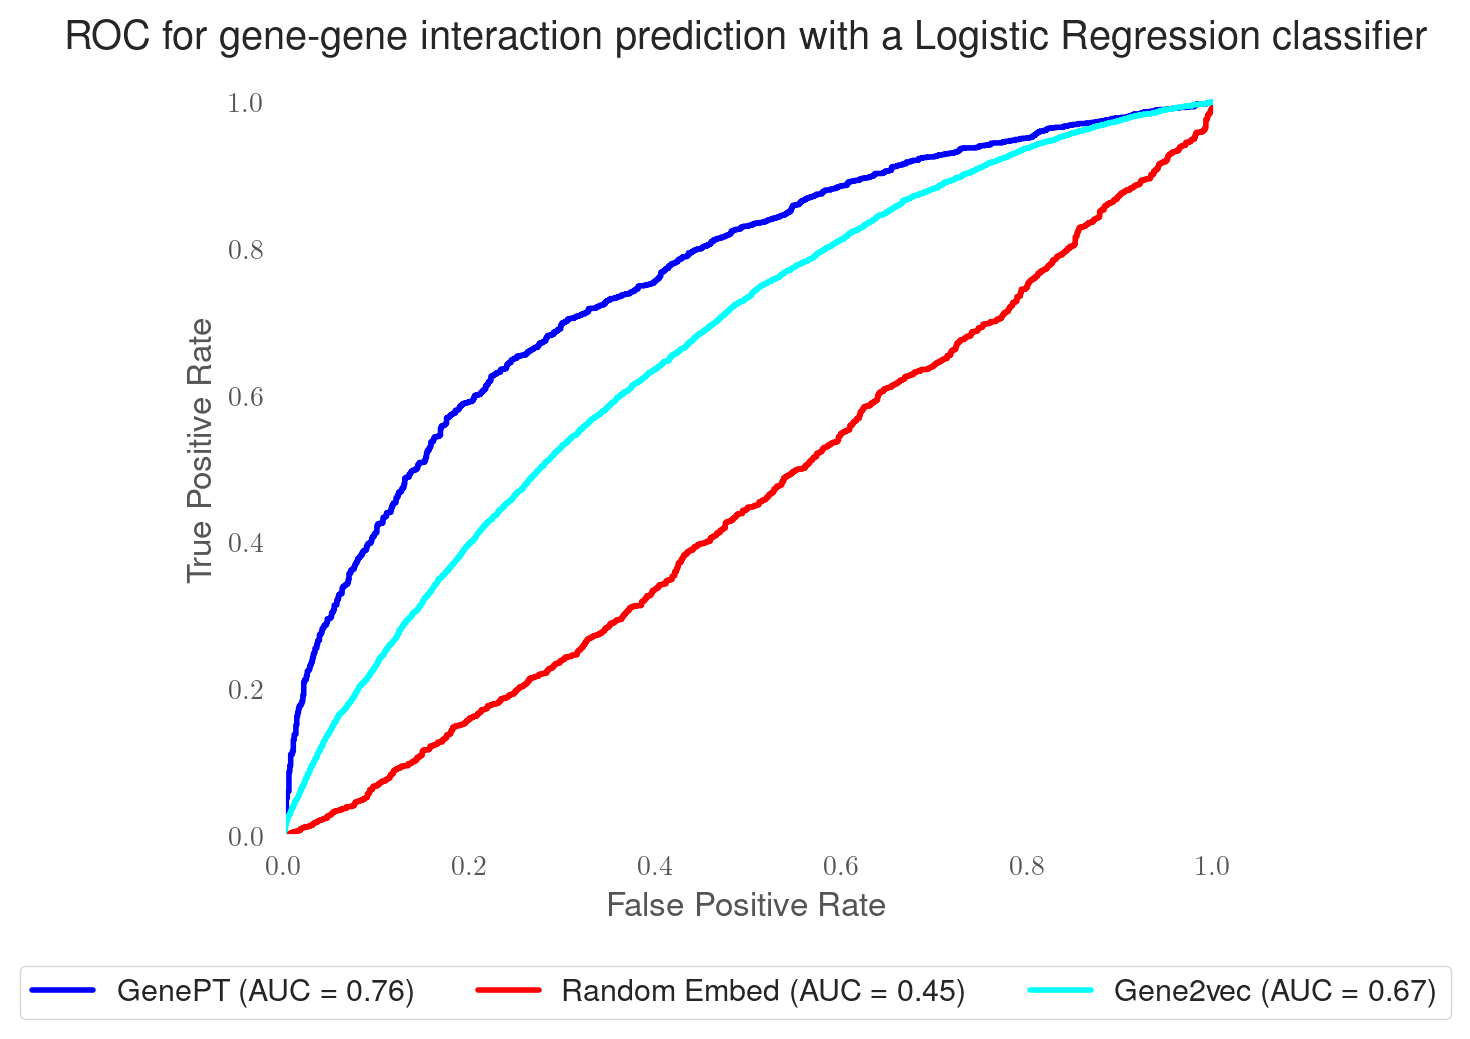

In [ ]:
# Plot ROC curves
plt.figure()
# Existing Logistic Regression curves
# ... your existing plot code for Logistic Regression here ...
plt.figure(figsize=(6,5))
# Add Random Forest ROC curves
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, 
         label='GenePT (AUC = %0.2f)' % (sklearn.metrics.roc_auc_score(y_array_test, y_pred_rf[:,1])))
plt.plot(fpr_random_rf, tpr_random_rf, color='red', lw=2, 
         label='Random Embed (AUC = %0.2f)' % (sklearn.metrics.roc_auc_score(y_array_test_random, y_pred_rf_random[:,1])))
plt.plot(fpr_gene2vec_rf, tpr_gene2vec_rf, color='cyan', lw=2, 
         label='Gene2vec (AUC = %0.2f)' % (sklearn.metrics.roc_auc_score(y_array_test_gene2vec, y_pred_rf_gene2vec[:,1])))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for gene-gene interaction prediction with a Logistic Regression classifier')
plt.legend(loc='upper left',bbox_to_anchor=(-0.3, -0.15),fontsize=11,ncol=3)